## 6.01 - Supervised Learning Model Comparison

Recall the "data science process."

1. Define the problem.
2. Gather the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus mostly on creating (and then comparing) many regression and classification models. Thus, we'll define the problem and gather the data for you.
Most of the questions requiring a written response can be written in 2-3 sentences.

### Step 1: Define the problem.

You are a data scientist with a financial services company. Specifically, you want to leverage data in order to identify potential customers.

If you are unfamiliar with "401(k)s" or "IRAs," these are two types of retirement accounts. Very broadly speaking:
- You can put money for retirement into both of these accounts.
- The money in these accounts gets invested and hopefully has a lot more money in it when you retire.
- These are a little different from regular bank accounts in that there are certain tax benefits to these accounts. Also, employers frequently match money that you put into a 401k.
- If you want to learn more about them, check out [this site](https://www.nerdwallet.com/article/ira-vs-401k-retirement-accounts).

We will tackle one regression problem and one classification problem today.
- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

Check out the data dictionary [here](http://fmwww.bc.edu/ec-p/data/wooldridge2k/401KSUBS.DES).

### NOTE: When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable. When predicting `e401k`, you may use the entire dataframe if you wish.

### Step 2: Gather the data.

##### 1. Read in the data from the repository.

In [222]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
#Import model validation and preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
#Import regression, metric, and regularization packages
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV



In [203]:
df = pd.read_csv('401ksubs.csv')

In [204]:
df.head(2)

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
0,0,13.17,0,0,40,1,4.575,0,1,173.4489,1600
1,1,61.23,0,1,35,1,154.000,1,0,3749.1130,1225


##### 2. What are 2-3 other variables that, if available, would be helpful to have?

Home Location; Occupation

##### 3. Suppose a peer recommended putting `race` into your model in order to better predict who to target when advertising IRAs and 401(k)s. Why would this be an unethical decision?

Because the model can be used to discriminate based on this variable.

## Step 3: Explore the data.

##### 4. When attempting to predict income, which feature(s) would we reasonably not use? Why?

In [205]:
df.isnull().sum()

e401k     0
inc       0
marr      0
male      0
age       0
fsize     0
nettfa    0
p401k     0
pira      0
incsq     0
agesq     0
dtype: int64

In [206]:
df.dtypes

e401k       int64
inc       float64
marr        int64
male        int64
age         int64
fsize       int64
nettfa    float64
p401k       int64
pira        int64
incsq     float64
agesq       int64
dtype: object

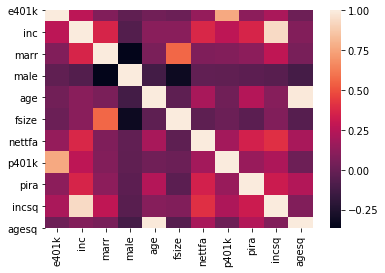

In [207]:
sns.heatmap(df.corr());

In [208]:
df.corr()['inc'].sort_values(ascending=False)

inc       1.000000
incsq     0.940161
nettfa    0.376586
pira      0.364354
marr      0.362008
p401k     0.270833
e401k     0.268178
fsize     0.110170
age       0.105638
agesq     0.087305
male     -0.069871
Name: inc, dtype: float64

In [209]:
df.describe().T['min']

e401k       0.0000
inc        10.0080
marr        0.0000
male        0.0000
age        25.0000
fsize       1.0000
nettfa   -502.3020
p401k       0.0000
pira        0.0000
incsq     100.1601
agesq     625.0000
Name: min, dtype: float64

**In the following order of strong income prediction:** Net Financial Asasets (nettfa), Marital Status (marr), Family Size(fsize), Age (age)

##### 5. What two variables have already been created for us through feature engineering? Come up with a hypothesis as to why subject-matter experts may have done this.
> This need not be a "statistical hypothesis." Just brainstorm why SMEs might have done this!

The squared terms were likely created through polynomial feature engineering in an attempt to increase the predictive quality of their models.



##### 6. Looking at the data dictionary, one variable description appears to be an error. What is this error, and what do you think the correct value would be?

Both age and income have descriptions of squared features which we suspect not to be the case. These features should simply be age and income, without the square.

## Step 4: Model the data. (Part 1: Regression Problem)

Recall:
- Problem: What features best predict one's income?
- When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable.

##### 7. List all modeling tactics we've learned that could be used to solve a regression problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific regression problem and explain why or why not.

multiple linear regression model, lasso, ridge, elasticnet, k-nearest neighbors model, decision tree, random forest, Kneighbors regressor, Adaboost, SVM


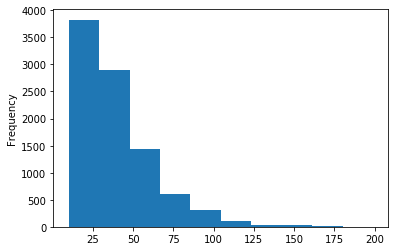

In [210]:
df['inc'].plot(kind='hist');

##### 8. Regardless of your answer to number 7, fit at least one of each of the following models to attempt to solve the regression problem above:
    - a multiple linear regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector regressor
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend setting a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [211]:
y = df['inc']

In [212]:
X = df[['nettfa', 'marr', 'fsize', 'age']]

In [265]:
regression_models = {
    'Lin': LinearRegression(),
    'KNR': KNeighborsRegressor(),
    'DTR': DecisionTreeRegressor(),
    'Bag': BaggingRegressor(random_state=42),
    'Ada': AdaBoostRegressor(random_state=42),
    'SVR': SVR(),  
}

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.33)

In [214]:
X_train.skew().sort_values(ascending=False)

nettfa    9.561055
fsize     0.728968
age       0.397852
marr     -0.515991
dtype: float64

In [217]:
pt = PowerTransformer()
pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

pt_y = PowerTransformer()
pt_y.fit(y_train.to_frame())
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

In [230]:
ss = StandardScaler()
ss.fit(X_train_pt)
X_train_pt_ss = ss.transform(X_train_pt)
X_test_pt_ss = ss.transform(X_test_pt)

In [244]:
def fit_score_regressor_model(model,train_data,train_values):

    train_cv_results = cross_val_score(model, train_data, train_values, cv=3).mean()
    
    model.fit(train_data, train_values)
    
    test_results = model.score(X_test_pt_ss,y_test_pt)
    
    return (train_cv_results, test_results)
    

In [245]:
lr = KNeighborsRegressor()
lr.fit(X_train_pt_ss, y_train_pt)
cross_val_score(lr,X_train_pt_ss, y_train_pt).mean()

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.28375125455846434

In [264]:
with warnings.catch_warnings():
   
    # ignore all caught warnings
    warnings.filterwarnings("ignore")

    for key in regression_models.keys():
        print()
        print(key)
        model = regression_models[key]
        model.fit(X_train_pt_ss, y_train_pt)
        print(f"Train Score: {cross_val_score(model, X_train_pt_ss, y_train_pt, cv = 5).mean()}")
        print(f"Test Score: {cross_val_score(model, X_test_pt_ss, y_test_pt, cv = 5).mean()}")
        print()
        train_preds = model.predict(X_train_pt_ss)
        test_preds = model.predict(X_test_pt_ss)
        print(f"RMSE Train: {mean_squared_error(y_train_pt, train_preds) **.5}")
        print(f"RMSE Test: {mean_squared_error(y_test_pt, test_preds) **.5}")


Lin
Train Score: 0.24167279613717563
Test Score: 0.2123522586861959

RMSE Train: 0.8665852229660725
RMSE Test: 0.8846982795821662

KNR
Train Score: 0.2765830988320596
Test Score: 0.30461280491320153

RMSE Train: 0.6866175399796198
RMSE Test: 0.8191234616460145

DTR
Train Score: -0.20128605114235554
Test Score: -0.14646925875959646

RMSE Train: 0.14391762579234144
RMSE Test: 1.084543497604798

Bag
Train Score: 0.25536720714060357
Test Score: 0.2890084373188867

RMSE Train: 0.37663313594740255
RMSE Test: 0.8486622924750093

Ada
Train Score: 0.3653720811575346
Test Score: 0.375741710295494

RMSE Train: 0.7879892575694732
RMSE Test: 0.7958752636826145

SVR
Train Score: 0.2099113598690679
Test Score: 0.15202162721092805

RMSE Train: 0.8860005800509401
RMSE Test: 0.907904892001006


In [266]:
lr = LinearRegression()
lr.fit(X_train_pt_ss, y_train_pt)
lr.coef_

array([[ 0.24321069,  0.47345165, -0.12772459,  0.05006565]])

In [273]:
X_train.columns

Index(['nettfa', 'marr', 'fsize', 'age'], dtype='object')

##### 9. What is bootstrapping?

Bootstrapping is the concept of resampling data with replacement. For each sample you take the same number of observations and compare the results. You maintain the same number (n) in order to fit your estimators on the same amount of data (prevents us from introducing another variable). Bagging is "bootstrap aggregation" -- it's a method in which models are trained on bootstrapped samples (each with their own particular model fit), aggregated, and scored. 

##### 10. What is the difference between a decision tree and a set of bagged decision trees? Be specific and precise!

A set of bagged decision trees is an ensemble modeling approach based on the principles of boostrapping and aggregation (aka bagging). This set of trees is set on randomized samples from the same training data, at which point results are aggregated and the model is assessed. This is helpful for a model like a DecisionTree-- this model in particular can overfit quickly on training data (particularly if hyperparamters like max depth are not specified).

##### 11. What is the difference between a set of bagged decision trees and a random forest? Be specific and precise!

The difference here is that a RandomForest model varies the set of features that each estimator within the ensemble model is trained on. In addition to varying the observations (as seen with bagging), the features are also varied. 

##### 12. Why might a random forest be superior to a set of bagged decision trees?
> Hint: Consider the bias-variance tradeoff.

It introduces more variety into the model fitting process, which in turn results in more randomness and will then generalize better beyond the test set (driving down variance).

## Step 5: Evaluate the model. (Part 1: Regression Problem)

##### 13. Using RMSE, evaluate each of the models you fit on both the training and testing data.

See #8 Above.

##### 14. Based on training RMSE and testing RMSE, is there evidence of overfitting in any of your models? Which ones?

DecisionTreeRegressor appears to be very bad -- the R2 score here is negative. Beyond this model, we are seeing pretty varied results between R2 and RMSE. Some of the models that are popping from an overfitting standpoint are our BaggingClassifier and KNR models. While majority of models are showing a small gap between training and test in terms of RMSE, these two in particular are showing sigificant gaps.

##### 15. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

I'm going to use LinearRegression here as the goal was the understand what features are most important. Based on this objective, I want to preserve interpretability as much as possible for internal stakeholders involved in this proccess. In addition to this, the RMSE is relatively close to some of our more advanced models.

##### 16. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

I would test ElasticNet, Ridge, and Lasso Regression here. I would also consider testing polynomial features.

## Step 4: Model the data. (Part 2: Classification Problem)

Recall:
- Problem: Predict whether or not one is eligible for a 401k.
- When predicting `e401k`, you may use the entire dataframe if you wish.

##### 17. While you're allowed to use every variable in your dataframe, mention at least one disadvantage of using `p401k` in your model.

p401k stands for 'participation in 401k.' We are estimating e401k which determines eligibility for 401k. The goal here is to identify potential customers. As this variable will be a strong predictor of eligiblity, it will be a significant component of our model. If we employ our model, we'll then be optimizing toward people that already have 401ks. While we might be able to lure them away from their current plans, the acqusition costs will be significant relative to customers without a 401k that satisfy our other criteria.

##### 18. List all modeling tactics we've learned that could be used to solve a classification problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific classification problem and explain why or why not.

logistic regression, naive bayes, KNeighbors, RandomForest, SVM, Adaboost, DecisionTrees, Bagged Trees, Voting Classifier

##### 19. Regardless of your answer to number 18, fit at least one of each of the following models to attempt to solve the classification problem above:
    - a logistic regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector classifier
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend using a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [156]:
X_class = df.drop(columns=['e401k', 'p401k'])
y_class = df['e401k']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_class,y_class,random_state=42, test_size=0.33)

In [173]:
models = {
    'Log': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Dec': DecisionTreeClassifier(random_state=42),
    'Ran': RandomForestClassifier(random_state=42),
    'Ada': AdaBoostClassifier(random_state=42),
    'SVC': SVC(random_state=42),  
}

In [219]:
def fit_score_model(model,train_data,train_values):

    train_cv_results = cross_val_score(model, train_data, train_values, cv=3).mean()
    
    model.fit(train_data, train_values)
    
    test_results = model.score(X_test,y_test)
    
    return (train_cv_results, test_results)
    

In [176]:
#Prevent warnings from flooding the screen
with warnings.catch_warnings():
   
    # ignore all caught warnings
    warnings.filterwarnings("ignore")

    for key in models.keys():
        train_results, test_results = fit_score_model(models[key],X_train,y_train)
        print(f"{key}'s Train Score: {round(train_results,2)}, Test Score: {round(test_results,2)}, Differennce: {round(np.abs(train_results -test_results),2)}.")
        print("")

Log's Train Score: 0.65, Test Score: 0.65, Differennce: 0.01.

KNN's Train Score: 0.6, Test Score: 0.62, Differennce: 0.02.

Dec's Train Score: 0.6, Test Score: 0.59, Differennce: 0.01.

Ran's Train Score: 0.65, Test Score: 0.65, Differennce: 0.0.

Ada's Train Score: 0.68, Test Score: 0.68, Differennce: 0.01.

SVC's Train Score: 0.6, Test Score: 0.61, Differennce: 0.01.



## Step 5: Evaluate the model. (Part 2: Classfication Problem)

##### 20. Suppose our "positive" class is that someone is eligible for a 401(k). What are our false positives? What are our false negatives?

In [186]:
y_class.value_counts(normalize=True)

0    0.607871
1    0.392129
Name: e401k, dtype: float64

In [181]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train,y_train)
preds=ada.predict(X_test)

In [182]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [183]:
print(fp)

392


We have 392 false positives in this workflow. **This represent the number of users that we predicted to not be eligible for a 401k but in fact were eligble for a 401k.**

##### 21. In this specific case, would we rather minimize false positives or minimize false negatives? Defend your choice.

The positive class in this classification problem is "users not eligible for a 401k"....

A **False Positive** is: A user that our model classified as not being eligible for a 401k but in fact is.
A **False Negative** is: A user that our model classified as being eligible for a 401k but in fact is not.

In this case, I would be more interested in minimizing false negatives. We'd effectively be spending money against users that will not be able to open a product that we are advertising to them.

##### 22. Suppose we wanted to optimize for the answer you provided in problem 21. Which metric would we optimize in this case?

Here we'd want to look at Specifiity.

##### 23. Suppose that instead of optimizing for the metric in problem 21, we wanted to balance our false positives and false negatives using `f1-score`. Why might [f1-score](https://en.wikipedia.org/wiki/F1_score) be an appropriate metric to use here?

F1 Score is a metric you want to use when you are balancing Precision with Recall. In this case, we would be minimiing both the spend against ineligble targets, and improving our ability to identify eligible targets that we were not previously surfacing through our model.

##### 24. Using f1-score, evaluate each of the models you fit on both the training and testing data.

In [187]:
from sklearn.metrics import f1_score

In [199]:
    for key in models.keys():
        model = models[key]
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        print(key) 
        print(f1_score(pred_train,y_train))
        
        pred_test = model.predict(X_test)
        print(f1_score(pred_test,y_test))

Log
0.4686436558094312
0.46394351991931415


C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KNN
0.6395759717314489
0.47005029721079106
Dec
1.0
0.4813895781637717
Ran
0.9649122807017544
0.4885496183206106
Ada
0.5777479892761394
0.5508982035928144


C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC
0.9955028618152085
0.011522633744855966


##### 25. Based on training f1-score and testing f1-score, is there evidence of overfitting in any of your models? Which ones?

KNN, Decision Tree, SVC are all severely overfit.

##### 26. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

Adaboost appears to  be a strong contender. It's showing stability across training and test data sets. While it's slightly overfit, parameter tuning may enable us to reduce this.

##### 27. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

I would gridsearch n_estimators and learning rate to hypertune. I would also consider plugging AdaBoost in with another series of models as part of a larger voting classifier.

## Step 6: Answer the problem.

##### BONUS: Briefly summarize your answers to the regression and classification problems. Be sure to include any limitations or hesitations in your answer.

- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.